<a href="https://colab.research.google.com/github/DmitryKhrenov/Autoencoder/blob/main/%D0%A1%D1%82%D0%B0%D0%B6%D0%B8%D1%80%D0%BE%D0%B2%D0%BA%D0%B0_Selector_%D0%A1%D0%BE%D1%81%D1%82%D0%B0%D0%B2%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BA%D0%B0%D1%80%D1%82%D1%8B_%D1%86%D0%B2%D0%B5%D1%82%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Константы

In [ ]:
###-------  Подключаем общие библиотеки --------------
import os
import math
import time


# Подключение библиотеки для работы с массивами
import numpy as np 
# Подключение библиотеки для генерации случайных чисел
import random


# нахождение максимов и пр.матобработка для поиска цветов
from scipy import ndimage
from scipy.ndimage import maximum_filter
from scipy.ndimage import generic_filter
from scipy.ndimage import label, generate_binary_structure
from scipy.ndimage import measurements
from scipy.spatial import distance
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

# Подключение библиотек для отрисовки изображений
import matplotlib.pyplot as plt 
# Вывод изображения в ноутбуке, а не в консоли или файле
%matplotlib inline 

# Подключение класса для работы с изображением
from PIL import Image, ImageOps
import cv2
from google.colab.patches import cv2_imshow



In [ ]:
#DATA_DIR = '/content/drive/MyDrive/res_Selector'
DATA_DIR = 'res_Selector'
#DATA_DIR = 'res224_Selector'
TRAIN_DIR = DATA_DIR + '/training'
VAL_DIR = DATA_DIR + '/validation'


img_width, img_height = (512, 512)

## Функции

### Общие

In [ ]:
def files_cnt(folder):
    total = 0
    for root, dirs, files in os.walk(folder):
        total += len(files)
    return total
    
# очистить и удалить папку с картинкаим
def remove_data_dir(DATA_DIR):
    !rm -r -d $DATA_DIR    

In [ ]:
def remake_dirs_inside(source_dir, target_dir):
    remove_data_dir(target_dir)
    !mkdir $target_dir
    for root, dirs, files in os.walk(source_dir):
        # Создаем папки в target_dir, если их нет
        for dirname in dirs:
#            dir_path = os.path.join(root.replace(source_dir, target_dir), dirname)
            dir_path = os.path.join(target_dir, root, dirname)
            os.makedirs(dir_path, exist_ok=True)

### Работа с картинками

##### **image_chage_base**(img, mask_color = (0,0,0), cmap = 'BGR'):
Заменить изображение подложки 

In [ ]:
# заменить изображение подложки 
def image_chage_base(img, mask_color = (0,0,0), cmap = 'BGR'):

    img = img.astype('uint8')

    # Преобразуйте изображение в черно-белое
    if cmap == 'BGR': c_conv = cv2.COLOR_BGR2GRAY
    if cmap == 'RGB': c_conv = cv2.COLOR_RGB2GRAY
    if cmap == 'HSV': c_conv = cv2.COLOR_HSV2GRAY
    
    # Преобразуйте изображение в черно-белое
    gray = cv2.cvtColor(img, c_conv)

    # Применение порогового фильтра
    ret, thresh = cv2.threshold(gray, 250, 255, cv2.THRESH_BINARY_INV)
    # создаем структурирующее ядро
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    # применяем операцию замыкания
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    # находим контуры
    contours, hierarchy = cv2.findContours(closed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # создание маски для выделения контуров на изображении 1
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    cv2.drawContours(mask, contours, -1, (255,255,255), -1)

    # создание маски для копирования содержимого контуров на изображение 2
    inv_mask = cv2.bitwise_not(mask)

    # копирование содержимого контуров на изображение 2
    image2 = np.zeros(img.shape, dtype=np.uint8)
    image2[:, :] = mask_color       # цвет заливки

    # заполнение пространства внутри контуров выбранным цветом
    cv2.fillPoly(image2, contours, (0, 0, 0))


    image1_masked = cv2.bitwise_and(img, img, mask=mask)
    result = cv2.add(image1_masked, image2 )

    return result  

##### Перенести цвета с картинки на цветовую 3D плоскость

In [ ]:
# plane : (255,255,255 ) - 3D плоскоть в 4D пространстве. точка на плоскости - частота появления цвета с координатами в цветовом пространстве
def transfer_color(plane, img):
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            c = img[x, y]
            plane [c[0], c[1], c[2] ] += 1
    return plane

##### **get_main_colors(img, num_clusters = None, in_cmap = 'BGR', out_cmap = 'RGB')** Получить основные цвета с картинки

In [ ]:
import numpy as np 
from sklearn.cluster import KMeans

def get_main_colors(img, num_clusters = None, in_cmap = 'BGR', out_cmap = 'RGB'):
   
    # Преобразование изображения в массив
    img_array = img.reshape((-1, 3))

    # Создание объекта KMeans
    if num_clusters:   kmeans = KMeans(n_init='auto', n_clusters=num_clusters)
    else: kmeans = KMeans(n_init='auto')

    # Обучение модели KMeans на массиве цветов
    kmeans.fit(img_array)

    # Получение центров кластеров
    colors = kmeans.cluster_centers_[:10]

    if  ((in_cmap == 'RGB') and (out_cmap == 'BGR')) or ((in_cmap == 'BGR') and (out_cmap == 'RGB')):
        colors = colors [:, ::-1]       # перейдем к световой модели cv2 #colors = cv2.cvtColor(colors.astype(int), cv2.COLOR_RGB2BGR) 

    # получить метки кластеров
    labels = kmeans.labels_

    # подсчитать размеры кластеров
    sizes = np.bincount(labels)

    
    # Объединение массивов по первому столбцу
    result = np.concatenate((sizes.reshape(-1,1), colors), axis=1).astype(int)
    result = result[result[:, 0].argsort()[::-1]]

    # Создание булевого массива для удаления строк
#    mask = np.all(result[:, -3:] == [0,0,0], axis=1)
    mask = np.sum(result[:, -3:], axis=1) <= 3  # здесь завязано на маску по черному цвету - отсекаем группы цветов, у которых ясркость меньше 3 - х 

    # Удаление строк из массива
    return result[~mask]


##### **color_grouping(colors_freq, dist = 50, min_fraction_slice = None)** Объединить кластеры с близкими цветами
на вход 4N отсортированная матрица, расстояние объединения, доля для игнорирования

In [ ]:
import numpy as np 
from scipy.spatial import distance
from scipy.spatial.distance import cdist

def color_grouping(colors_freq, dist = 50, min_fraction_slice = None):
  
    colors_len = colors_freq.shape[0]            # сколько кластеров передано на группировку
    new_colors = []
    summator = np.zeros(colors_freq.shape[1], dtype = np.uint8)
    total_weigth = np.sum(colors_freq[:,0])     # сумма долей/точек поступивших кластеров
    if min_fraction_slice:                      # с каким количеством  точек отбрасывать итоговые кластеры
#        slice_level = int(total_weigth * min_fraction_slice)
        slice_level = int(min_fraction_slice * 1000)

    i=0
    c = 0       # количество группируемых значений. но зачем ограничивать 
    while (i < colors_len) and (c < 100):
        c += 1
        v = colors_freq[i][0]
        summator = np.array([v, colors_freq[i][1] * v, colors_freq[i][2] * v, colors_freq[i][3] * v])

        j = i + 1
        while (j < colors_len):
            d = distance.euclidean(colors_freq[i][1:], colors_freq[j][1:])

            if d > dist:
                break 
            else:
                v1 = colors_freq[j][0]
                v += v1
                summator += [v1, colors_freq[j][1] * v1, colors_freq[j][2] * v1, colors_freq[j][3] * v1]
                colors_freq = np.delete(colors_freq, j, axis=0)
                colors_len -= 1
                # j увеличивать не надо, т.к. удалили строку

        summator[1:] = summator[1:] / v
#        summator = summator / v
        summator[0] = summator[0] * 1000 / total_weigth  

        if (i==0) or  not (min_fraction_slice) or  ((min_fraction_slice) and ( summator[0] > slice_level)):
            new_colors.append(summator)
        i = j

    return np.array(new_colors)



##### **image_color_samples**(img, color_samples, samples_wide = 0.2, max_samples = 10, max_sample_size = 0.08)
нарисовать N-цетовых сэмплов на изображении


In [ ]:
def image_color_samples(img, color_samples, samples_wide = 0.2, max_samples = 10, max_sample_size = 0.08):
    # на всякий случай переведм  значения цветов в целое
    color_weight = []

    if (color_samples.shape[1]) == 4:
        color_weight = color_samples[:,0]
        color_samples = np.round(color_samples[:,1:]).clip(0, 255).astype(np.uint8)
    else: 
        color_samples = np.round(color_samples).clip(0, 255).astype(np.uint8)

    # получение размеров изображения
    h, w = img.shape[:2]
    # вычисление ширины добавляемой области
    border_width = int(w * 0.2)
    # добавление пустой области справа
    img_border = cv2.copyMakeBorder(img, 0, 0, 0, border_width, cv2.BORDER_REPLICATE, value = (255,255,255))

    # вычисление размера фигуры
    part_step = min( h / (min(color_samples.shape[0], max_samples) + 1), border_width)
    part_width = int(part_step * 0.8) 
    part_offs = int(part_step / 2)

    # создание изображения для отображения цветовых квадратов
    color_img = np.zeros((part_width, part_width, 3), dtype=np.uint8)

    x = int(w + border_width * 0.1)
    for i, color in enumerate(color_samples):
        # заполнение квадрата цветом
        color_img[:, :, :] = color[::-1]
 
        # вывод квадрата на изображение
        y = part_offs + int( i * part_step)
        if (i >= max_samples) or ( y + part_width >= h): break

        img_border[y : y + part_width, x : x + part_width, :] = color_img
        if len(color_weight) > 0:
            cv2.putText(img_border,f'{(color_weight[i]/10):2.1f}', (x,y), cv2.FONT_HERSHEY_SIMPLEX, 0.4, [0,0,0], 1)

    return img_border

##### **image_main_colors(img_file_name, image = None, num_clusters = 7, dist = 50, min_fraction_slice = 0.2,  in_cmap = 'BGR', out_cmap = 'RGB' )** Получение основных цветов картинки
Возвращает строку, содержащую полное имя картинки (или текстовую метку), и массив 4N цветов с их долями.
Тип возвращаемой строки `dt = np.dtype([('fname_col', 'U250'), ('colors_col', object)])`
Если img=None, то пытается загрузить картинку по имени.
Если DATA_DIR опрtделена, то добавляется к имени при загрузке, но не сохраняется в выходном массиве

In [ ]:
dt = np.dtype([('fname_col', 'U250'), ('colors_col', object)])
colors = np.empty((0,), dtype=dt)

def image_main_colors(img_file_name, image = None, num_clusters = 7, dist = 50, min_fraction_slice = 0.2,  in_cmap = 'BGR', out_cmap = 'RGB' ):
    if image is None:     # значит надо вычитать из файла
        if ('DATA_DIR' in vars() ) and (DATA_DIR != '') and (DATA_DIR != None): 
            s = os.path.join(DATA_DIR, img_file_name)
        else:
            s = img_file_name
        if not os.path.exists(os.path.join(SAMP_DIR, img_file_name)):
            raise Exception(f'File "{s}"" not exist')
        else:
            image = cv2.imread(s)                       # по умолчанию загружает в формате 'bgr'
            if  (in_cmap == 'RGB'):
                 image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

    
    img_under_mask = image_chage_base(image, (0,0,0), cmap = in_cmap)     # заливка черным цветом по контуру
    
    main_colors = get_main_colors(img_under_mask, num_clusters = num_clusters, in_cmap = in_cmap, out_cmap = out_cmap)

    main_colors = color_grouping(main_colors, dist = dist, min_fraction_slice = min_fraction_slice)
    
    return np.array([(img_file_name, main_colors)], dtype=dt)[0]

#### Показать картинки, по N в одну строку

In [ ]:
def show_images(images, labels=None, file_names=None, per_line=None, min_size = 2):

    img_cnt = len(images)

    if labels: l_cnt = len(labels)
    else: l_cnt = 0

    if per_line: h_cnt = per_line
    else:        h_cnt = round(img_cnt ** (0.5))  # корень квадратный
    
    v_cnt  = img_cnt // h_cnt
    if img_cnt % h_cnt: v_cnt += 1


    h_len = 20  # ширина/высота полотна в дюймах
    a = 20 // h_cnt
    v_len = v_cnt * a

    # Рисуем изображения в виде квадратной сетки h_cnt x v_cnt
    fig, axes = plt.subplots(v_cnt, h_cnt, figsize=(h_len, v_len)) #count, 1, figsize=(10,10))
    axes = axes.ravel()
    for i in np.arange(0, len(axes)):
        if i < img_cnt:
            # Преобразование в RGB
            axes[i].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB) ) 
        if i < l_cnt:
            axes[i].set_title(labels[i])        #f"Label: {labels[i]}, File Name: {file_names[i]}" if i < l_cnt else str(i))
        axes[i].axis('off')
    plt.subplots_adjust(wspace=0.5)
    plt.show()
 
 

## Загрузка картинок

In [ ]:
#Ссылка на расшаренную папку с выгрузкой файлов
LINK = 'https://drive.google.com/file/d/1YNjf0GblmA6Y7aYuopK1OnVpx5oD9602'  # res_Selector.zip  (512,512)
#идентификтаор файла Google
archive_id = LINK.split('?')[0].split('/')[-1]                 # archive_id = '1YNjf0GblmA6Y7aYuopK1OnVpx5oD9602'

LOAD_DIR = '/content'
data_arch_file='/content/Images.zip'

!rm -f $data_arch_file
!gdown -O $data_arch_file  $archive_id

Downloading...
From: https://drive.google.com/uc?id=1YNjf0GblmA6Y7aYuopK1OnVpx5oD9602
To: /content/Images.zip
100% 450M/450M [00:08<00:00, 50.3MB/s]


In [ ]:
# удалим папку с картинками
if 'DATA_DIR' in globals():     # если существует переменная DATA_DIR
    remove_data_dir(DATA_DIR)

rm: cannot remove 'res_Selector': No such file or directory


In [ ]:
# Распакуем и установим DATA_DIR
# запомним все папки, перед распаковкой
tmp_dir_lst = []
for d in os.listdir('.'):
    if os.path.isdir(d):
        tmp_dir_lst.append(d)

!unzip -q $data_arch_file

for d in os.listdir('.'):
    if os.path.isdir(d):
        if d not in tmp_dir_lst:
            DATA_DIR = d                    # первая появившаяся папка будет папкой с данными
            break

del tmp_dir_lst

In [ ]:
#DATA_DIR = 'res_Selector'

## Считаем определяем для каждой картики ее цвета

In [ ]:
# Используем генераторное выражение, чтобы получить список файлов с их именами
img_files = [os.path.join(root, file) for root, dirs, files in os.walk(DATA_DIR) for file in files]


In [ ]:
# пересоздать структуру папок для сохранение картинок с указанными цветами
SAMP_DIR = 'drive/MyDrive/SAMP_2'   # сюда будем сохранять картинки с тестовыми цветами

# данные удалятся
remake_dirs_inside(DATA_DIR, SAMP_DIR)


rm: cannot remove 'drive/MyDrive/SAMP_2': No such file or directory


In [ ]:
COLORS_DIR = 'drive/MyDrive/COLORS_2'    
remove_data_dir(COLORS_DIR)
!mkdir $COLORS_DIR

rm: cannot remove 'drive/MyDrive/COLORS_2': No such file or directory


In [ ]:
SAMP_DIR = 'drive/MyDrive/SAMP_2'

# Определение структурированного типа данных
# Создаем структурированный массив
dt = np.dtype([('fname_col', 'U250'), ('colors_col', object)])

colors = np.empty((0,), dtype=dt)


start_time = time.time()


imgs_cnt = files_cnt(DATA_DIR)
print('Всего файлов: ', imgs_cnt )
a_step = 200 / imgs_cnt
a = 0
a_pos = 0

counter = 0
f_counter = 0
p = 0

for root, dirs, files in os.walk(DATA_DIR):
#  if f_counter >= 500: break  # записываем за раз 
  
  for img_name in files:
    counter += 1
    a += a_step
    if a >= a_pos:
        cur_time = time.time()
        duration = cur_time - start_time
        hours, remainder = divmod(duration, 3600)
        minutes, seconds = divmod(remainder, 60)

        print(f'\r {a_pos / 200 * 100:2.2f}% Пропущено {p} Длительность {int(hours)}:{int(minutes)}:{int(seconds)} Зависано {f_counter} файлов',end = '')
        a_pos += 1

    if os.path.exists(os.path.join(SAMP_DIR, root, img_name)):              # пропускаем, если такой файл уже обработали
        p += 1
        print(f'\r {a_pos / 0.4:2.2f}% Пропущено {p}',end = '')
        continue

    img3 = cv2.imread(os.path.join(root, img_name))                         # всегда читает в BGR

    img_under_mask = image_chage_base(img3, (0,0,0))                        # cmap = 'BGR'
    
    main_colors = get_main_colors(img_under_mask, num_clusters = 5)         # in_cmap = 'BGR', out_cmap = 'RGB'

    main_colors = color_grouping(main_colors, dist = 75, min_fraction_slice = 0.20)

    img_with_samples = image_color_samples(img3, main_colors[:, 1:])        # 3 последние стобца - цвет  ## img_cmap = 'BRG', clr_cmap = 'RGB'
  
#    images.append(img_with_samples)

    new_row = np.array([(os.path.join(root, img_name), main_colors)], dtype=dt)
    colors = np.append(colors,  new_row)

    cv2.imwrite(os.path.join(SAMP_DIR, root, img_name), img_with_samples)

    f_counter +=1 # считаем только записанные файлы

    if (f_counter > 0) and ( f_counter % 100 == 0):
        np.save(os.path.join(COLORS_DIR,str(counter)+'_colors.npy'), np.array(colors))
        colors = np.empty((0,), dtype=dt)    
if f_counter > 0:
    np.save(os.path.join(COLORS_DIR,str(counter)+'_colors.npy'), np.array(colors))  # остаток списка
#show_images(images, per_line = 6)

Всего файлов:  17405
 99.50% Пропущено 0 Длительность 1:39:40 Зависано 17317 файлов

In [ ]:
# Объединение массивов в один
colors = np.empty((0,), dtype=dt)    

c = 0
f = 0

path = COLORS_DIR
for name in os.listdir(path):
    file = os.path.join(path, name)
    if os.path.isfile(file) and file.endswith(".npy"):
        print(file)
        # загрузка массива
        new_row = np.load(file, allow_pickle = True)
        colors = np.append(colors,  new_row)
        f += 1

    c += 1
print(colors.shape)

drive/MyDrive/COLORS_2/100_colors.npy
drive/MyDrive/COLORS_2/200_colors.npy
drive/MyDrive/COLORS_2/300_colors.npy
drive/MyDrive/COLORS_2/400_colors.npy
drive/MyDrive/COLORS_2/500_colors.npy
drive/MyDrive/COLORS_2/600_colors.npy
drive/MyDrive/COLORS_2/700_colors.npy
drive/MyDrive/COLORS_2/800_colors.npy
drive/MyDrive/COLORS_2/900_colors.npy
drive/MyDrive/COLORS_2/1000_colors.npy
drive/MyDrive/COLORS_2/1100_colors.npy
drive/MyDrive/COLORS_2/1200_colors.npy
drive/MyDrive/COLORS_2/1300_colors.npy
drive/MyDrive/COLORS_2/1400_colors.npy
drive/MyDrive/COLORS_2/1500_colors.npy
drive/MyDrive/COLORS_2/1600_colors.npy
drive/MyDrive/COLORS_2/1700_colors.npy
drive/MyDrive/COLORS_2/1800_colors.npy
drive/MyDrive/COLORS_2/1900_colors.npy
drive/MyDrive/COLORS_2/2000_colors.npy
drive/MyDrive/COLORS_2/2100_colors.npy
drive/MyDrive/COLORS_2/2200_colors.npy
drive/MyDrive/COLORS_2/2300_colors.npy
drive/MyDrive/COLORS_2/2400_colors.npy
drive/MyDrive/COLORS_2/2500_colors.npy
drive/MyDrive/COLORS_2/2600_colors

In [ ]:
# проверим , всели файлы обработаны (могли выпадать при прерываниях)
apsent = []
for img_name in img_files:
    matching_indices = np.where(colors['fname_col'] == img_name)[0]
    if len(matching_indices) == 0:
        apsent.append(img_name)
        print(f"Строки с первым элементом, равным {img_name}, нет в массиве.")


Строки с первым элементом, равным res_Selector/validation/t-shirt women/11923337_8999984_480.jpg, нет в массиве.
Строки с первым элементом, равным res_Selector/validation/t-shirt women/19283750_42461488_480.jpg, нет в массиве.
Строки с первым элементом, равным res_Selector/validation/t-shirt women/19512992_43638656_480.jpg, нет в массиве.
Строки с первым элементом, равным res_Selector/validation/t-shirt women/19686793_44529290_480.jpg, нет в массиве.
Строки с первым элементом, равным res_Selector/validation/t-shirt women/17238657_35207625_480.jpg, нет в массиве.
Строки с первым элементом, равным res_Selector/validation/t-shirt women/131.png, нет в массиве.
Строки с первым элементом, равным res_Selector/validation/t-shirt women/355.jpg, нет в массиве.
Строки с первым элементом, равным res_Selector/validation/t-shirt women/146.jpg, нет в массиве.
Строки с первым элементом, равным res_Selector/validation/t-shirt women/895.jpg, нет в массиве.
Строки с первым элементом, равным res_Selector/

In [ ]:
# догрузим выпавшие файлы
colors_apsent = np.empty((0,), dtype=dt)    
for img_name in apsent:
    img3 = cv2.imread(os.path.join(img_name))
    print(img_name)
    img_under_mask = image_chage_base(img3, (0,0,0))

    main_colors = get_main_colors(img_under_mask, num_clusters = 5)
    main_colors = color_grouping(main_colors, dist = 75, min_fraction_slice = 0.20)
    img_with_samples = image_color_samples(img3, main_colors[:, 1:])        # 3 последние стобца - цвет
    #images.append(img_with_samples)

    new_row = np.array([(img_name, main_colors)], dtype=dt)
    colors_apsent = np.append(colors_apsent,  new_row)

    cv2.imwrite(os.path.join(SAMP_DIR, img_name), img_with_samples)
    f_counter +=1 # считаем только записанные файлы
    if (f_counter > 0) and ( f_counter % 100 == 0):
        np.save(os.path.join(COLORS_DIR,str(counter)+'_a_colors.npy'), np.array(colors_apsent))
        colors_apsent = np.empty((0,), dtype=dt)   

if f_counter > 0:
    np.save(os.path.join(COLORS_DIR,str(counter)+'_a_colors.npy'), np.array(colors_apsent))  # остаток списка

#show_images(images, per_line = 6)

res_Selector/validation/t-shirt women/11923337_8999984_480.jpg
res_Selector/validation/t-shirt women/19283750_42461488_480.jpg
res_Selector/validation/t-shirt women/19512992_43638656_480.jpg
res_Selector/validation/t-shirt women/19686793_44529290_480.jpg
res_Selector/validation/t-shirt women/17238657_35207625_480.jpg
res_Selector/validation/t-shirt women/131.png
res_Selector/validation/t-shirt women/355.jpg
res_Selector/validation/t-shirt women/146.jpg
res_Selector/validation/t-shirt women/895.jpg
res_Selector/validation/t-shirt women/300.jpg
res_Selector/validation/t-shirt women/15247707_26437491_480.jpg
res_Selector/validation/t-shirt women/15333525_26900584_480.jpg
res_Selector/validation/t-shirt women/12138987_10117516_480.jpg
res_Selector/validation/t-shirt women/255.jpg
res_Selector/validation/t-shirt women/673.jpg
res_Selector/validation/t-shirt women/998.jpg
res_Selector/validation/t-shirt women/15700264_30170426_480.jpg
res_Selector/validation/t-shirt women/724.jpg
res_Selecto

In [ ]:
# удалим дубликаты. тоже появлялись при прерываниях

# получение уникальных значений первого столбца
unique_vals, unique_indices = np.unique(colors['fname_col'] , return_index=True)

# проверка, какие строки содержат эти значения более одного раза
duplicate_indices = [index for val, index in zip(unique_vals, unique_indices) if np.count_nonzero(colors['fname_col']  == val) > 1]

# удаление строк с повторяющимися значениями в первом столбце
colors = np.delete(colors, duplicate_indices, axis=0)
print('Удалено : ', len(duplicate_indices))
print('Осталось : ', colors.shape[0])

np.save(os.path.join(COLORS_DIR,'_colors.npy'), np.array(colors))  # остаток списка

Удалено :  0
Осталось :  17310


## Эксперименты

#### Наличие дубликатов названий файлов в папке SAMP_DIR

In [ ]:
import os
from collections import Counter

def find_duplicate_files(directory):
    files_counter = Counter()

    for root, dirs, files in os.walk(directory):
        for file in files:
            full_path = os.path.join(root, file)
            files_counter[full_path] += 1

    duplicate_files = [file for file, count in files_counter.items() if count > 1]

    return duplicate_files

In [ ]:
SAMP_DIR = 'drive/MyDrive/SAMP'

duplicates = find_duplicate_files(SAMP_DIR)
duplicates


[]

#### Пример определения контуров

res_Selector/training/dress casual/19648629_44401082_1000.jpg


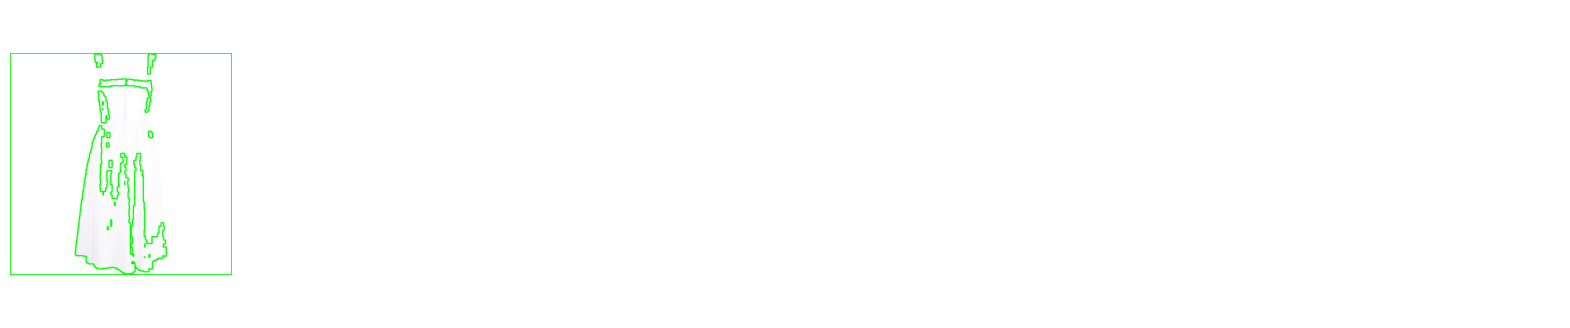

In [ ]:
images = []
for img_name in ['res_Selector/training/dress casual/19648629_44401082_1000.jpg']: #.extend(random.sample(img_files, 20):
    print(img_name)
    img3 = cv2.imread(img_name)
    # Преобразование в оттенки серого
    gray = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)

    
    # Применение порогового фильтра
    ret, thresh = cv2.threshold(gray, 250, 255, cv2.THRESH_BINARY)

    # создаем структурирующее ядро
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))

    # применяем операцию замыкания
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # находим контуры
    contours, hierarchy = cv2.findContours(closed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    '''
    # Применение фильтра Гаусса для сглаживания изображения
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # Применение оператора Canny для обнаружения границ
    canny = cv2.Canny(blur, 250, 255)

    # Нахождение контуров на изображении
    contours, hierarchy = cv2.findContours(canny, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    '''
    # Отображение контуров на изображении
    cv2.drawContours(img3, contours, -1, (0, 255, 0), 2)
    # Отображение результата
    #cv2_imshow(img3)
    images.append(img3)

show_images(images, per_line = 5)





#### контроль наложения маски

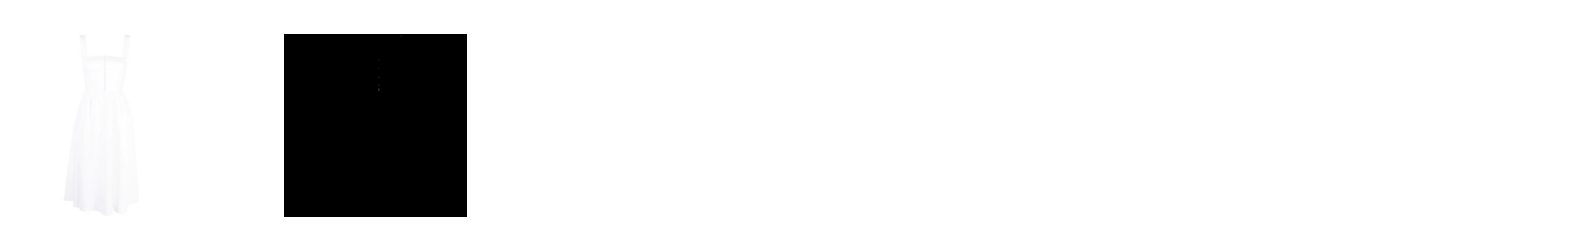

In [ ]:
images = []
for img_name in ['res_Selector/training/dress casual/19648629_44401082_1000.jpg']: #random.sample(img_files, 20):
    img3 = cv2.imread(img_name)
    images.append(img3)

    images.append(image_chage_base(img3, (0,0,0)))

show_images(images, per_line = 6)


#cv2_imshow(img2)

#plane =  np.zeros((256,256,256), dtype = np.uint8)

#heat_map = transfer_color(plane, img2)
#gray_arr = heat_map[:, :, 0] # выбираем зеленый канал



#### Далее

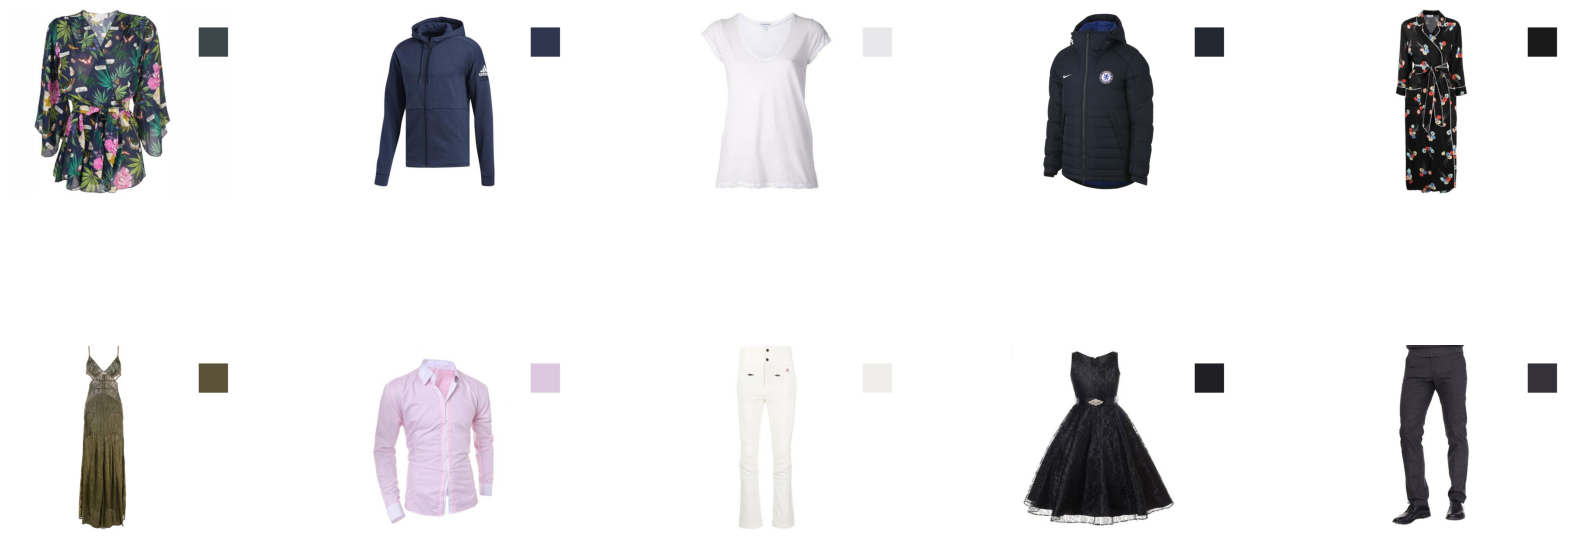

In [ ]:
images = []
steps = len(img_files)
labels = random.sample(img_files, 10)
for img_name in labels:
    img3 = cv2.imread(img_name)

    closed_colors = image_main_colors(img_name, image = img3, num_clusters=5, dist = 75, min_fraction_slice = 0.2)   
   
    img_with_samples = image_color_samples(img3, closed_colors[1][:, 1:])        # 3 последние стобца - цвет
  

    images.append(img_with_samples)

    l = [s[13:] for s in labels]

show_images(images,  per_line = 5)

In [ ]:
    closed_colors

('res_Selector/training/t-shirt women/587.jpg', array([[972,  33,  33,  43]]))

In [ ]:
labels

['res_Selector/training/sportswear women/19326480_43425161_1000.webp',
 'res_Selector/training/dress casual/17939617_40642023_1000.jpg',
 'res_Selector/training/trousers men/16464515_31855080_480.jpg',
 'res_Selector/training/t-shirt men/14123598_18935990_480.jpg',
 'res_Selector/training/t-shirt women/18698245_42210762_480.jpg']

In [ ]:
# маркируем связные области в массиве и создаем массив маркеров
arr = heat_map

# маркируем связные области в массиве и создаем массив маркеров
labels, num_features = label(arr)

# создаем массив размером (num_features, 2), содержащий значения из arr и их координаты
values = np.arange(num_features)[:, None]
coords = np.array(np.where(labels > 0)).T
#result = np.hstack((arr[coords[:, 0], coords[:, 1], coords[:, 2]][:, None], coords, values))

In [ ]:
from scipy.signal import convolve
# применяем фильтр скользящего среднего
# определяем размер окна фильтра
kernel_size = (3, 3, 3)

# создаем ядро для фильтра
kernel = np.ones(kernel_size) / np.prod(kernel_size)

# применяем фильтр скользящего среднего
arr = convolve(heat_map, kernel, mode='same')

In [ ]:
# применяем медианный фильтр радиусом 10 по манхэттенскому расстоянию
arr = ndimage.median_filter(heat_map, size=3, mode='reflect')
arr = heat_map

# получаем координаты ненулевых элементов исходного массива
coords = np.argwhere(arr != 0)

# отсортировываем массив координат по убыванию значения элементов исходного массива
sort_idx = np.argsort(arr[coords[:, 0], coords[:, 1], coords[:, 2]])
sorted_coords = coords[sort_idx]

# создаем итоговый массив
result = np.column_stack((arr[sorted_coords[:, 0], sorted_coords[:, 1], sorted_coords[:, 2]], sorted_coords))


In [ ]:
arr = heat_map
coords = np.argwhere(arr != 0)
sort_idx = np.argsort(arr[coords[:, 0], coords[:, 1], coords[:, 2]])
sorted_coords = coords[sort_idx]

result = np.column_stack((arr[sorted_coords[:, 0], sorted_coords[:, 1], sorted_coords[:, 2]], sorted_coords))

sum(arr[sorted_coords[:, 0], sorted_coords[:, 1], sorted_coords[:, 2]])

59136

In [ ]:
# нахождение локальных максимумов
radius = 5
footprint = np.ones((radius, radius, radius))
local_max = maximum_filter(heat_map, footprint=footprint) == heat_map

# нахождение координат локальных максимумов
coords_3d = np.argwhere(local_max)

coords_3d


array([[  0,   0,   5],
       [  0,   0,   6],
       [  0,   0,   7],
       ...,
       [255, 255, 247],
       [255, 255, 248],
       [255, 255, 249]])

In [ ]:
# применяем медианный фильтр радиусом 10 по манхэттенскому расстоянию
arr_filtered = ndimage.median_filter(heat_map, size=3, mode='reflect')

# нахождение координат локальных максимумов
coords_3d = np.argwhere(arr_filtered)

arr_filtered

In [ ]:
# определяем радиус окна
radius = 2

# определяем функцию для вычисления нового значения пикселя на основе окружающих пикселей
def sum_filter(values):
    return np.sum(values)

# применяем фильтр скользящего окна
arr_filtered = generic_filter(heat_map, sum_filter, size=2*radius+1)

arr_filtered

In [ ]:
coords_3d.shape

(16743397, 3)

In [ ]:
!pip install pympler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 KB 10.7 MB/s eta 0:00:00


In [ ]:
from pympler import asizeof

# создание трехмерного массива, представляющего исходный 3D массив целых значений
data = np.random.randint(0, 45000000000, size=(255, 255, 255))

'''
# нахождение локальных максимумов
footprint = np.ones((3, 3, 3))
local_max = maximum_filter(data, footprint=footprint) == data

# нахождение координат локальных максимумов
coords_3d = np.argwhere(local_max)

# проверка расстояний между пиками
distances = cdist(coords_3d, coords_3d)
for i in range(distances.shape[0]):
    for j in range(i+1, distances.shape[1]):
        if distances[i,j] < 10:
            # удаление одного из пиков из списка координат
            if coords_3d[i, 0] < coords_3d[j, 0]:
                coords_3d = np.delete(coords_3d, i, axis=0)
            else:
                coords_3d = np.delete(coords_3d, j, axis=0)
'''                
print(asizeof.asizeof(data)) 

132651160
